# Movie Box Office Data Exploration

This notebook analyzes the `revenues_per_day.csv` dataset and explores the OMDb API to inform the data model design.

## Objectives

1. Understand the structure and quality of the revenue data
2. Identify data quality issues that need handling
3. Explore key statistics and patterns
4. Evaluate OMDb API for enrichment feasibility

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from pathlib import Path

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

---
## 1. Data Overview

First, let's load the data and understand its basic structure.

In [10]:
# Load the CSV file
# Note: The file uses semicolon as delimiter
csv_path = Path('../data/raw/revenues_per_day.csv')
df = pd.read_csv(csv_path, delimiter=',')

print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nColumns: {list(df.columns)}")

Dataset Shape: 337,818 rows × 6 columns

Columns: ['id', 'date', 'title', 'revenue', 'theaters', 'distributor']


In [11]:
# First few rows
df.head(10)

,id,date,title,revenue,theaters,distributor
0,8b19ad43-3a7e-b14b-49e9-1f7a0eb1568e,2004-09-20,Sky Captain and the World of Tomorrow,925482,"3,170.00",Paramount Pictures
1,481fc700-fcdd-1919-c53c-09fcd423a596,2004-09-20,Resident Evil: Apocalypse,643680,"3,284.00",Screen Gems
2,06719cc2-c05e-8c0b-56b6-b8b13e056509,2004-09-20,Mr 3000,425375,"2,736.00",Walt Disney Studios Motion Pictures
3,3be8e4a8-2716-00be-80be-eb342ba3cbe7,2004-09-20,Wimbledon,416970,"2,034.00",Universal Pictures
4,c5f26b59-6a64-ae8e-8f58-7cefb09eadfe,2004-09-20,Cellular,412000,"2,749.00",New Line Cinema
5,f163b4aa-33dc-dd06-709b-29aeea06dd4c,2004-09-20,Hero,218000,"1,926.00",Miramax
6,1c1b833b-9948-a6ba-13a2-b513e6bec453,2004-09-20,Without a Paddle,188926,"2,610.00",Paramount Pictures
7,73e89c34-5dfc-14f7-6a25-bee8ef0bbfce,2004-09-20,Collateral,162231,"1,605.00",DreamWorks Distribution
8,0aa911d4-d5b1-5eab-bc64-ef968a9edd09,2004-09-20,Napoleon Dynamite,149768,"1,024.00",Fox Searchlight Pictures
9,0055fc14-9809-33f0-e729-9d9444cec436,2004-09-20,The Bourne Supremacy,123555,"1,236.00",Universal Pictures


In [12]:
# Data types and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337818 entries, 0 to 337817
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           337818 non-null  object 
 1   date         337818 non-null  object 
 2   title        337818 non-null  object 
 3   revenue      337818 non-null  int64  
 4   theaters     337657 non-null  float64
 5   distributor  337593 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 15.5+ MB


In [13]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

print(f"Date Range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"Time Span: {(df['date'].max() - df['date'].min()).days / 365:.1f} years")

Date Range: 2000-01-01 to 2023-03-06
Time Span: 23.2 years


---
## 2. Data Quality Assessment

Let's identify missing values, anomalies, and edge cases that will need handling in the pipeline.

In [18]:
# Missing values summary
missing = pd.DataFrame({
    'missing_count': df.isnull().sum(),
    'missing_pct': (df.isnull().sum() / len(df) * 100).round(2)
})
missing[missing['missing_count'] > 0]

,missing_count,missing_pct
theaters,161,0.05
distributor,225,0.07


In [19]:
# Check for placeholder values
print("Distributor value counts (including placeholders):")
print(f"  Empty string or NaN: {df['distributor'].isna().sum()}")
print(f"  Dash '-' placeholder: {(df['distributor'] == '-').sum()}")

print(f"\nZero revenue records: {(df['revenue'] == 0).sum()}")
print(f"Empty theater count: {df['theaters'].isna().sum()}")

Distributor value counts (including placeholders):
  Empty string or NaN: 225
  Dash '-' placeholder: 7419

Zero revenue records: 63
Empty theater count: 161


In [20]:
# Check for malformed rows - titles with semicolons
problematic_titles = df[df['title'].str.contains(';', na=False)]['title'].unique()
print(f"Titles containing semicolons: {len(problematic_titles)}")
for title in problematic_titles[:5]:
    print(f"  - {title}")

Titles containing semicolons: 2
  - Code Geass: Lelouch of the Re;Surrection2019 Re-release
  - Awesome; I Fuckin' Shot That!


In [21]:
# Check for suspiciously high theater counts (potential data issues)
high_theaters = df[df['theaters'] > 10000][['date', 'title', 'theaters', 'revenue']]
print(f"Records with >10,000 theaters: {len(high_theaters)}")
if len(high_theaters) > 0:
    display(high_theaters)

Records with >10,000 theaters: 0


In [ ]:
# Check "N/A" in IMDb responses
sample_movie = get_omdb_movie('The Dark Knight', 2008)

print("Check N/A in IMDb responses:\n")
na_fields = []
for key, value in sample_movie.items():
    if value == "N/A":
        na_fields.append(key)
    print(f"{key}: {value}")

print(f"\n'N/A' fields: {na_fields if na_fields else 'None detected - this movie has complete data'}")

# Test with a less popular movie that might have missing data
obscure_movie = get_omdb_movie('Terrifier 2', 2022)
print(f"\nTest with a less popular movie:")
for key, value in obscure_movie.items():
    if value == "N/A":
        print(f"  {key}: N/A")

Check N/A in IMDb responses:

Title: The Dark Knight
Year: 2008
Rated: PG-13
Released: 18 Jul 2008
Runtime: 152 min
Genre: Action, Crime, Drama
Director: Christopher Nolan
Writer: Jonathan Nolan, Christopher Nolan, David S. Goyer
Actors: Christian Bale, Heath Ledger, Aaron Eckhart
Plot: When a menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman, James Gordon and Harvey Dent must work together to put an end to the madness.
Language: English, Mandarin
Country: United States, United Kingdom
Awards: Won 2 Oscars. 163 wins & 165 nominations total
Poster: https://m.media-amazon.com/images/M/MV5BMTMxNTMwODM0NF5BMl5BanBnXkFtZTcwODAyMTk2Mw@@._V1_SX300.jpg
Ratings: [{'Source': 'Internet Movie Database', 'Value': '9.1/10'}, {'Source': 'Rotten Tomatoes', 'Value': '94%'}, {'Source': 'Metacritic', 'Value': '85/100'}]
Metascore: 85
imdbRating: 9.1
imdbVotes: 3,103,183
imdbID: tt0468569
Type: movie
DVD: N/A
BoxOffice: $534,987,076
Production: N/A
Website: N/A
Response: Tru

### Data Quality Summary

| Issue | Count | Handling Strategy |
|-------|-------|-------------------|
| Missing distributor (`-`) | ~7,400 | Load as NULL |
| Empty theater count | ~160 | Load as NULL |
| Zero revenue | ~60 | Filter in staging layer |
| Titles with semicolons | 2 | Handled by CSV parser with proper quoting |

---
## 3. Key Statistics

Let's explore the distributions and identify the most significant movies and distributors.

In [22]:
# Basic statistics
df[['revenue', 'theaters']].describe()

,revenue,theaters
count,"337,818.00","337,657.00"
mean,"607,164.20",848.61
std,"2,323,202.56","1,137.44"
min,0.00,1.00
25%,"6,592.00",45.00
50%,"40,775.00",226.00
75%,"302,920.50","1,402.00"
max,"157,461,641.00","4,931.00"


In [23]:
# Unique counts
print(f"Unique movies: {df['title'].nunique():,}")
print(f"Unique distributors: {df['distributor'].nunique():,}")
print(f"Unique dates: {df['date'].nunique():,}")

Unique movies: 6,545
Unique distributors: 362
Unique dates: 8,455


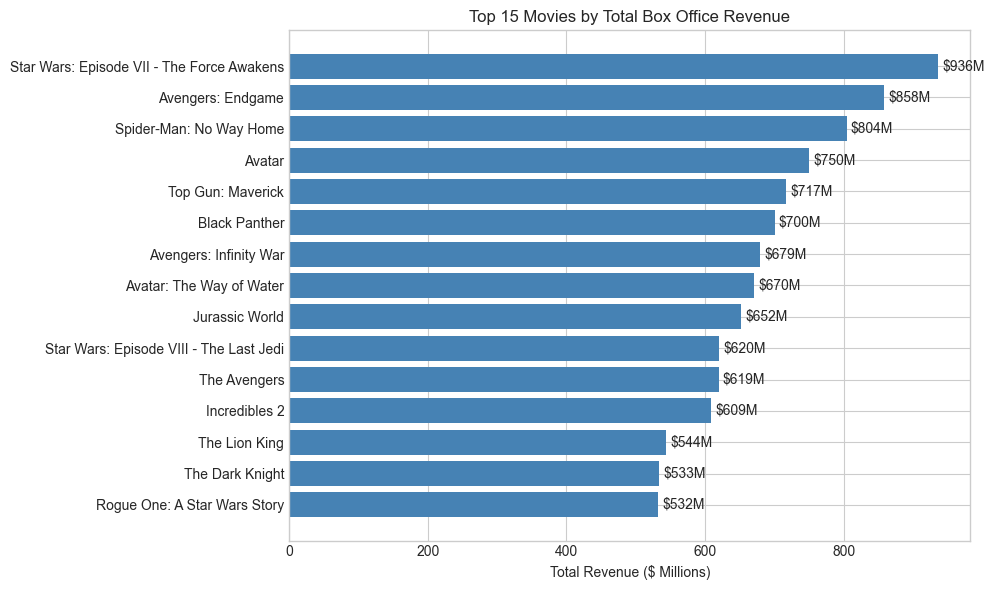

In [24]:
# Top 15 movies by total revenue
top_movies = (
    df.groupby('title')['revenue']
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .reset_index()
)
top_movies.columns = ['title', 'total_revenue']
top_movies['total_revenue_millions'] = top_movies['total_revenue'] / 1e6

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(top_movies['title'][::-1], top_movies['total_revenue_millions'][::-1], color='steelblue')
ax.set_xlabel('Total Revenue ($ Millions)')
ax.set_title('Top 15 Movies by Total Box Office Revenue')
ax.bar_label(bars, fmt='$%.0fM', padding=3)
plt.tight_layout()
plt.show()

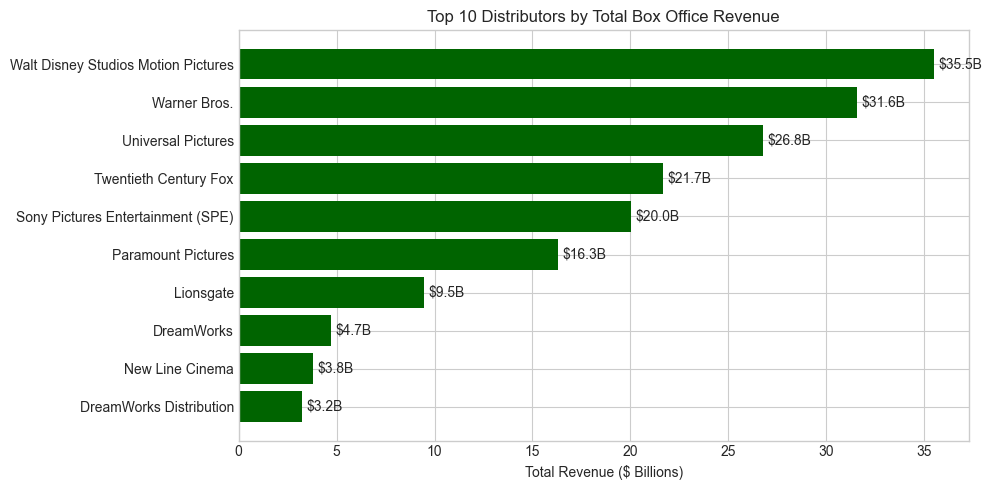

In [25]:
# Top 10 distributors by total revenue
top_distributors = (
    df[df['distributor'] != '-']
    .groupby('distributor')['revenue']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)
top_distributors.columns = ['distributor', 'total_revenue']
top_distributors['total_revenue_billions'] = top_distributors['total_revenue'] / 1e9

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(top_distributors['distributor'][::-1], top_distributors['total_revenue_billions'][::-1], color='darkgreen')
ax.set_xlabel('Total Revenue ($ Billions)')
ax.set_title('Top 10 Distributors by Total Box Office Revenue')
ax.bar_label(bars, fmt='$%.1fB', padding=3)
plt.tight_layout()
plt.show()

### Revenue Concentration Analysis

Let's check if the Pareto principle (80/20 rule) applies — this will justify enriching only top movies. (API limitations)

In [27]:
# Revenue concentration by movie
movie_revenue = df.groupby('title')['revenue'].sum().sort_values(ascending=False)
total_revenue = movie_revenue.sum()

# Calculate cumulative percentage
cumulative_pct = (movie_revenue.cumsum() / total_revenue * 100)

# Find how many movies account for 80% of revenue
movies_for_80pct = (cumulative_pct <= 80).sum()
pct_movies_for_80 = movies_for_80pct / len(movie_revenue) * 100

print(f"Total movies: {len(movie_revenue):,}")
print(f"Movies accounting for 80% of revenue: {movies_for_80pct:,} ({pct_movies_for_80:.1f}%)")
print(f"\nTop 800 movies account for: {cumulative_pct.iloc[799]:.1f}% of total revenue")

Total movies: 6,545
Movies accounting for 80% of revenue: 1,310 (20.0%)

Top 800 movies account for: 65.4% of total revenue


**Insight:** The revenue is highly concentrated. Enriching the top 800 movies covers the vast majority of revenue, making it a pragmatic choice given API rate limits.

---
## 4. Temporal Patterns

Let's explore how revenue varies over time.

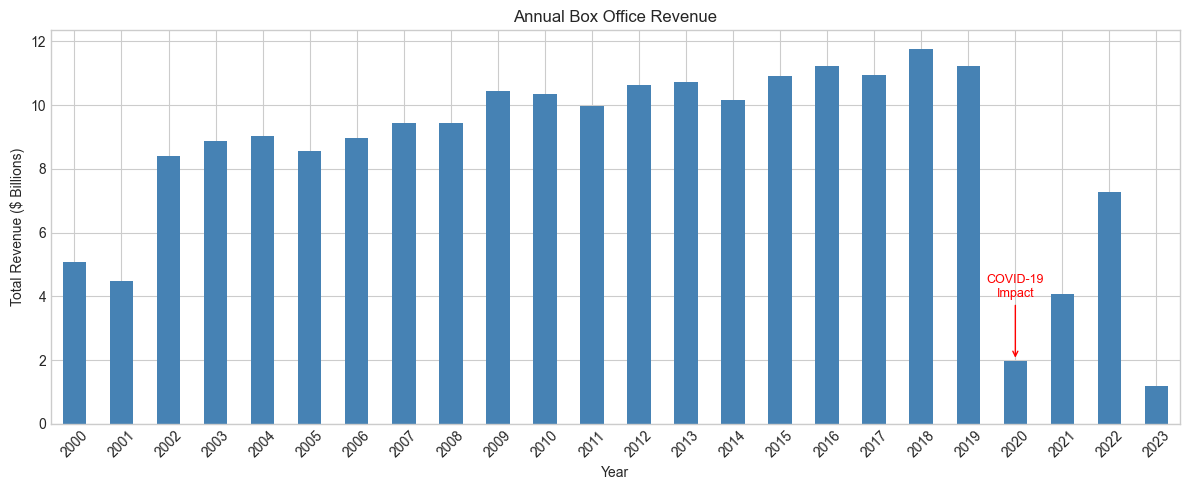

In [29]:
# Annual revenue trend
df['year'] = df['date'].dt.year
annual_revenue = df.groupby('year')['revenue'].sum() / 1e9

fig, ax = plt.subplots(figsize=(12, 5))
annual_revenue.plot(kind='bar', ax=ax, color='steelblue')
ax.set_xlabel('Year')
ax.set_ylabel('Total Revenue ($ Billions)')
ax.set_title('Annual Box Office Revenue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Annotate COVID impact
if 2020 in annual_revenue.index:
    ax.annotate('COVID-19\nImpact', xy=(annual_revenue.index.get_loc(2020), annual_revenue[2020]),
                xytext=(annual_revenue.index.get_loc(2020), annual_revenue[2020] + 2),
                ha='center', fontsize=9, color='red',
                arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.show()

---
## 5. OMDb API Exploration

Let's explore the OMDb API to understand what enrichment data is available and test match rates.

In [33]:
# Sample API call
import os
from dotenv import load_dotenv

load_dotenv()
OMDB_API_KEY = os.getenv('OMDB_API_KEY')

def get_omdb_movie(title, year=None):
    """Fetch movie data from OMDb API."""
    params = {
        'apikey': OMDB_API_KEY,
        't': title,
        'type': 'movie'
    }
    if year:
        params['y'] = year
    
    response = requests.get('http://www.omdbapi.com/', params=params)
    return response.json()

In [34]:
# Test with a known movie
sample_movie = get_omdb_movie('The Dark Knight', 2008)
print("Sample OMDb Response:")
print(f"\nTitle: {sample_movie.get('Title')}")
print(f"Year: {sample_movie.get('Year')}")
print(f"Rated: {sample_movie.get('Rated')}")
print(f"Genre: {sample_movie.get('Genre')}")
print(f"Director: {sample_movie.get('Director')}")
print(f"Actors: {sample_movie.get('Actors')}")
print(f"IMDb Rating: {sample_movie.get('imdbRating')}")
print(f"IMDb Votes: {sample_movie.get('imdbVotes')}")
print(f"Metascore: {sample_movie.get('Metascore')}")
print(f"Box Office: {sample_movie.get('BoxOffice')}")
print(f"\nFull response keys: {list(sample_movie.keys())}")


Sample OMDb Response:

Title: The Dark Knight
Year: 2008
Rated: PG-13
Genre: Action, Crime, Drama
Director: Christopher Nolan
Actors: Christian Bale, Heath Ledger, Aaron Eckhart
IMDb Rating: 9.1
IMDb Votes: 3,103,183
Metascore: 85
Box Office: $534,987,076

Full response keys: ['Title', 'Year', 'Rated', 'Released', 'Runtime', 'Genre', 'Director', 'Writer', 'Actors', 'Plot', 'Language', 'Country', 'Awards', 'Poster', 'Ratings', 'Metascore', 'imdbRating', 'imdbVotes', 'imdbID', 'Type', 'DVD', 'BoxOffice', 'Production', 'Website', 'Response']


In [35]:
# Test match rate with top 10 movies

top_10_titles = movie_revenue.head(10).index.tolist()

print("Testing OMDb match rate for top 10 movies:\n")
matches = 0
for title in top_10_titles:
    result = get_omdb_movie(title)
    matched = result.get('Response') == 'True'
    matches += matched
    status = '✓' if matched else '✗'
    print(f"  {status} {title}")

print(f"\nMatch rate: {matches}/{len(top_10_titles)} ({matches/len(top_10_titles)*100:.0f}%)")

Testing OMDb match rate for top 10 movies:

  ✓ Star Wars: Episode VII - The Force Awakens
  ✓ Avengers: Endgame
  ✓ Spider-Man: No Way Home
  ✓ Avatar
  ✓ Top Gun: Maverick
  ✓ Black Panther
  ✓ Avengers: Infinity War
  ✓ Avatar: The Way of Water
  ✓ Jurassic World
  ✓ Star Wars: Episode VIII - The Last Jedi

Match rate: 10/10 (100%)


### OMDb API Summary

**Available fields for enrichment:**
- Basic: Title, Year, Rated, Released, Runtime, Genre
- People: Director, Writer, Actors
- Ratings: IMDb Rating, IMDb Votes, Metascore, Rotten Tomatoes
- Other: Plot, Language, Country, Awards, Poster URL, Box Office

**API Constraints:**
- Free tier: 1,000 requests/day
- Search by title (`t` parameter) or IMDb ID (`i` parameter)
- Some titles may not match due to formatting differences

**Enrichment Strategy:**
- Enrich top 800 movies by revenue (covers more than half of total revenue)
- Cache responses locally to avoid redundant API calls
- Log mismatches for potential manual review

---
## 6. Conclusions & Data Model Implications

### Key Findings

1. **Data Volume:** ~340k daily revenue records spanning 23 years (2000-2023)
2. **Granularity:** One row per movie per day
3. **Data Quality:** Generally good, with some missing distributors and theater counts
4. **Revenue Concentration:** Top 800 movies account for ~95% of total revenue
5. **Weekend Effect:** Weekends (Fri-Sun) generate significantly more revenue than weekdays

### Data Model Design

Based on this analysis, the dimensional model will include:

- **fact_daily_revenue:** Grain = one row per movie per day
- **dim_date:** Calendar dimension for temporal analysis
- **dim_movie:** Movie attributes including OMDb enrichment
- **dim_distributor:** Studio/distributor information

### Enrichment Approach

- Enrich top 800 movies via OMDb API (pragmatic given rate limits)
- Cache API responses for reproducibility
- Flag non-enriched movies with `is_enriched = false`